In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
seed = 42

is_convolutional = True
save_model = False
save_synthetic_samples = True

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'


if is_convolutional:
    arch_tag = 'convolutional_arch'
    discriminator = convolutional_discriminator
    adaptive_training = 0.8
else:
    arch_tag = 'mlp_arch'
    discriminator = mlp_discriminator
    adaptive_training = None

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

6778 files containing complete point clouds were found.


In [6]:
max_epochs = 200
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}

noise_dim = 512
init_lr = 0.0005
leak = 0.1

n_syn_samples = train_data.num_examples  # Same number as original GT data.
accum_syn_data = []
train_stats = []

disc_kwargs = {'non_linearity': leaky_relu(leak)}

reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim, 
             discriminator, point_cloud_generator, 
             disc_kwargs=disc_kwargs)

In [ ]:
if do_training:
    for _ in range(max_epochs):
#         checkpoint_path = osp.join(train_dir, model_saver_id)
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params, adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
#         if save_model:
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

1 (1.127077726336817, 1.5464105045353924) 99.2045049667
2 (0.83503443273631006, 2.0770369807879132) 88.1728920937
3 (0.80195272192358968, 2.5085184269481235) 82.7725670338


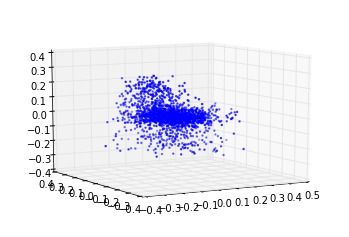

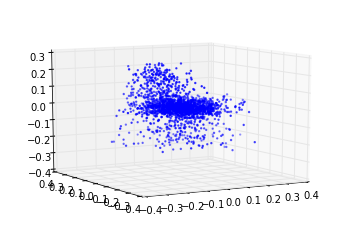

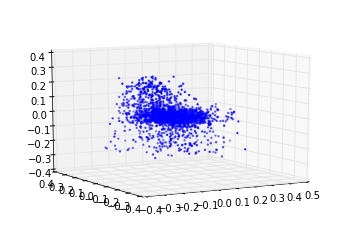

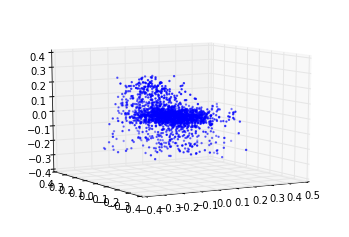

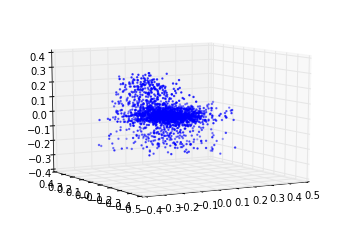

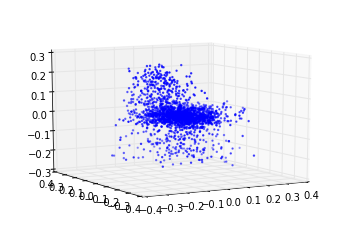

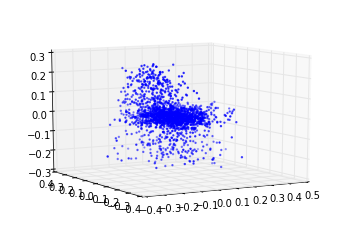

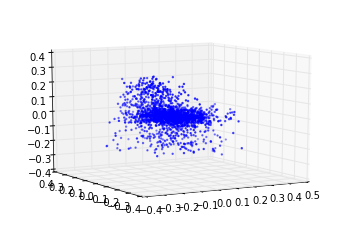

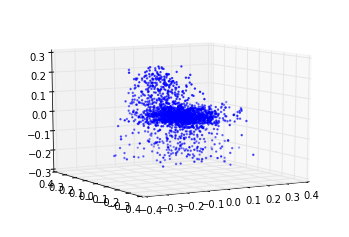

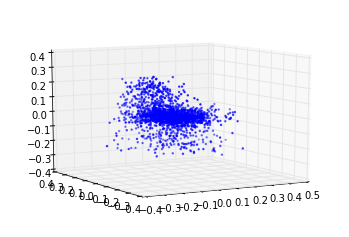

In [15]:
if do_plotting:
    epoch_to_check = 18
    n_check = 10
    check_data = accum_syn_data[epoch_to_check-1]
    rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
    for i in range(n_check):
        Point_Cloud(check_data[rids[i]]).plot()    

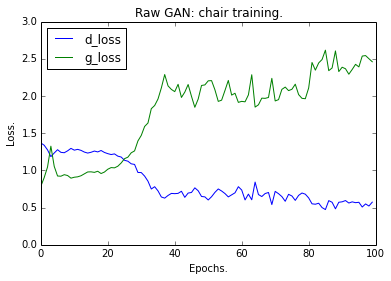

In [69]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN: %s training.' %(class_name,))
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
# TODO - save results.
save_out = osp.join(synthetic_data_out_dir, experiment_name + '_' + str(max_epochs) + 'epochs')
np.savez(save_out, accum_syn_data)